In [2]:
%pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [7]:
import pandas as pd

# Đọc dữ liệu từ file CSV
df = pd.read_csv("../data/merge_price_sentiment/FPT_final_training_data.csv")
df["Date"] = pd.to_datetime(df["Date"], errors="coerce")

# Lọc từ 2024-05-16 trở đi (nếu bạn cần giữ một mốc thời gian cụ thể)
df = df[df["Date"] >= "2022-05-16"]

# Loại bỏ các dòng không có nhãn
df = df.dropna(subset=["Target_Label"])

# Chuyển sentiment về số nguyên
for col in ["positive", "neutral", "negative", "total_articles"]:
    df[col] = df[col].fillna(0).astype(int)

# Loại bỏ nhãn 0 (giá không đổi) nếu không muốn dự đoán nó
df = df[df["Target_Label"] != 0]

df.shape  # Xem số lượng mẫu còn lại




(682, 15)

In [8]:
from sklearn.model_selection import train_test_split

features = ["positive", "neutral", "negative", "total_articles"]
X = df[features]
y = df["Target_Label"]

# Chia tập train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


In [9]:
from xgboost import XGBClassifier

# Dùng binary classification
model = XGBClassifier(
    objective="binary:logistic", 
    eval_metric="logloss",
    use_label_encoder=False,
    random_state=42
)

# Chuyển nhãn -1, 1 thành 0 và 1 vì XGBoost không dùng -1
y_train_bin = (y_train == 1).astype(int)
y_test_bin = (y_test == 1).astype(int)

model.fit(X_train, y_train_bin)


c:\Users\Admin\anaconda3\envs\StockPredict\Lib\site-packages\xgboost\training.py:183: UserWarning: [22:17:07] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, ...)

In [10]:
from sklearn.metrics import classification_report

y_pred_bin = model.predict(X_test)

print("📋 Classification Report:")
print(classification_report(y_test_bin, y_pred_bin, target_names=["Down", "Up"]))


📋 Classification Report:
              precision    recall  f1-score   support

        Down       0.46      0.28      0.35        64
          Up       0.53      0.71      0.61        73

    accuracy                           0.51       137
   macro avg       0.50      0.50      0.48       137
weighted avg       0.50      0.51      0.49       137



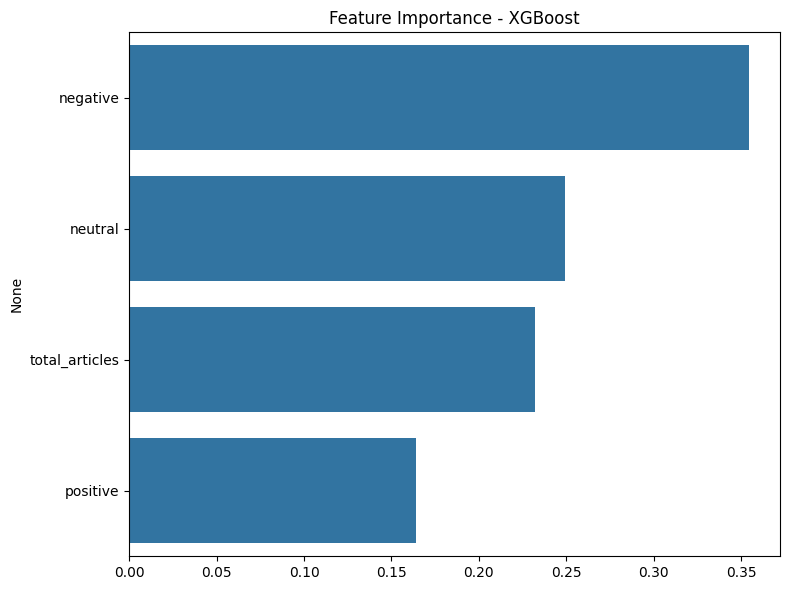

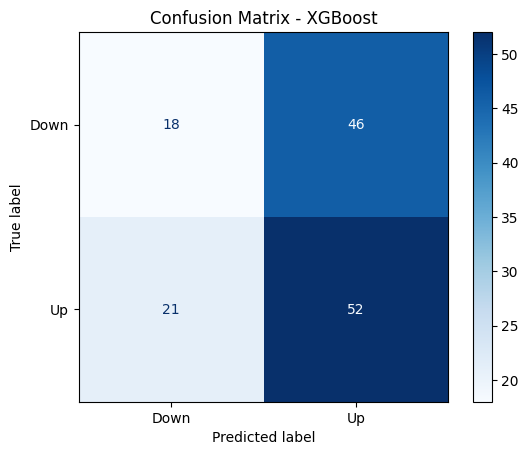

Classification Report:
              precision    recall  f1-score   support

        Down       0.46      0.28      0.35        64
          Up       0.53      0.71      0.61        73

    accuracy                           0.51       137
   macro avg       0.50      0.50      0.48       137
weighted avg       0.50      0.51      0.49       137



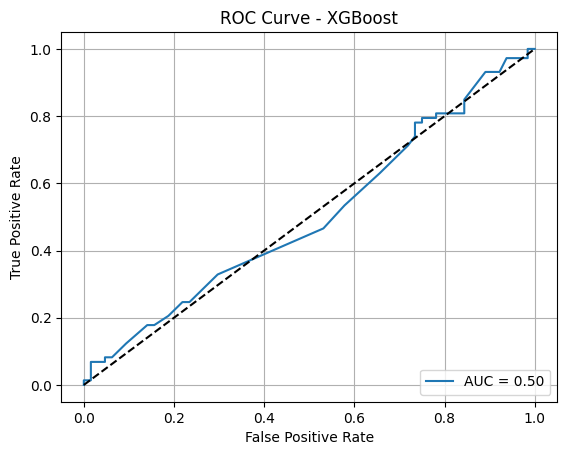

In [11]:

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc, classification_report

# Feature importance
importances = model.feature_importances_
feature_names = X_train.columns
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(8, 6))
sns.barplot(x=importances[indices], y=feature_names[indices])
plt.title("Feature Importance - XGBoost")
plt.tight_layout()
plt.show()

# Confusion matrix
y_pred = model.predict(X_test)
cm = confusion_matrix(y_test_bin, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Down", "Up"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - XGBoost")
plt.show()

# Classification report
print("Classification Report:")
print(classification_report(y_test_bin, y_pred, target_names=["Down", "Up"]))

# ROC curve
if len(np.unique(y_test_bin)) == 2:
    y_prob = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test_bin, y_prob)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
    plt.plot([0, 1], [0, 1], "k--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve - XGBoost")
    plt.legend(loc="lower right")
    plt.grid()
    plt.show()
